In this notebook, an U-net model is used to detect steel defects.

## Part 0: Import libraries

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
from keras import backend as K
from keras.models import Model, load_model
from keras.layers import Input, BatchNormalization, Activation, Dense, Dropout
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D, GlobalMaxPool2D
from keras.layers.merge import concatenate, add
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.preprocessing import image

# graphs
% matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams["font.size"] = 15
import seaborn as sns
from sklearn.model_selection import train_test_split

import numpy as np
import pandas as pd
from collections import defaultdict
from pathlib import Path
import random
import cv2
import os
import glob
import urllib.request


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Part 1: Upload data

#### 1.1 Option 1. loadng data from g-drive

In [ ]:
#unzip data image folders in g-drive 
#only do it once
! unzip 'drive/My Drive/steel_defects/train_images.zip' -d 'drive/My Drive/steel_defects/train_images'
! unzip 'drive/My Drive/steel_defects/test_images.zip' -d 'drive/My Drive/steel_defects/test_images'

#### 1.2 Option 2. upload data from Kaggle

In [ ]:
os.environ['KAGGLE_USERNAME'] = "ycf" # username from the json file 
os.environ['KAGGLE_KEY'] = "7adfc6c4e6c5eec087031fbb7397aee" # key from the json file (This key is incorrect5)

In [ ]:
!pip install -q kaggle
!kaggle competitions download -c severstal-steel-defect-detection -p /content/

  0% 0.00/6.91M [00:00<?, ?B/s]
100% 6.91M/6.91M [00:00<00:00, 113MB/s]
  0% 0.00/141k [00:00<?, ?B/s]
100% 141k/141k [00:00<00:00, 150MB/s]
100% 1.16G/1.16G [00:08<00:00, 152MB/s]
100% 1.16G/1.16G [00:08<00:00, 143MB/s]
 93% 120M/129M [00:00<00:00, 122MB/s]
100% 129M/129M [00:01<00:00, 125MB/s]


In [ ]:
!unzip -q /content/train.csv.zip -d /content/train.csv/
!unzip -q /content/train_images.zip -d /content/train_images/
!unzip -q /content/test_images.zip -d /content/test_images/

#### 2. Define the paths

In [ ]:
DIRin1 = "/content/drive/My Drive/CSTU1 - Steel"        # for option 1 above
#DIRin1 = "/content"                                    # for option 2
DIRtrain = os.path.join(DIRin1,"train_images")
DIRtest = os.path.join(DIRin1,"test_images")

# save path
weights_path = os.path.join(DIRin1,"DefectDetection.h5")
history_path = os.path.join(DIRin1,"DefectDetection_history.csv")
print("DIRin1 =", os.listdir(DIRin1))

print("The size of Train images\t:",len(os.listdir(DIRtrain)))
print("The size of Test images\t\t:",len(os.listdir(DIRtest)))
#print("The size of Train images\t:",len(os.listdir("/content/train_images")))
#print("The size of Test images\t\t:",len(os.listdir("/content/test_images")))

DIRin1 = ['References', 'Current code and results', '.ipynb_checkpoints', 'test_images', 'sample_submission.csv', 'train.csv', 'train_images', 'Backup', 'NewMasksFunction.ipynb', 'submission_v3.csv', 'DefectDetection.h5']
The size of Train images	: 12568
The size of Test images		: 5506


#### 3. read text data

In [ ]:
train_df = pd.read_csv("/content/drive/My Drive/CSTU1 - Steel/train.csv")
sample_df = pd.read_csv("/content/drive/My Drive/CSTU1 - Steel/sample_submission.csv")
#train_df = pd.read_csv("/content/train.csv/train.csv")
#sample_df = pd.read_csv("/content/sample_submission.csv")

In [ ]:
train_df.head()

,ImageId_ClassId,EncodedPixels
0,0002cc93b.jpg_1,29102 12 29346 24 29602 24 29858 24 30114 24 3...
1,0002cc93b.jpg_2,NaN
2,0002cc93b.jpg_3,NaN
3,0002cc93b.jpg_4,NaN
4,00031f466.jpg_1,NaN


In [ ]:
# transform class to columns
train_df['fname'], train_df['cls'] = zip(*train_df['ImageId_ClassId'].str.split('_'))
train_df["cls"] = train_df["cls"].astype(int)
train_df = train_df.pivot(index='fname',columns='cls',values='EncodedPixels')
train_df['defects'] = train_df.count(axis=1)

In [ ]:
train_df.head()

cls,1,2,3,4,defects
fname,,,,,
0002cc93b.jpg,29102 12 29346 24 29602 24 29858 24 30114 24 3...,NaN,NaN,NaN,1
00031f466.jpg,NaN,NaN,NaN,NaN,0
000418bfc.jpg,NaN,NaN,NaN,NaN,0
000789191.jpg,NaN,NaN,NaN,NaN,0
0007a71bf.jpg,NaN,NaN,18661 28 18863 82 19091 110 19347 110 19603 11...,NaN,1


In [ ]:
# presence of defects in each images
no_defects_num = np.sum(train_df["defects"] == 0)
defects_num = len(train_df) - no_defects_num

print("the number of images with no defects: {}".format(no_defects_num))
print("the number of images with defects: {}".format(defects_num))

the number of images with no defects: 5902
the number of images with defects: 6666


In [ ]:
# number of defects for each class
class_defects = len(train_df) - train_df.isnull().sum()
class_defects[:4]

cls
1     897
2     247
3    5150
4     801
dtype: int64

## Part 2: Visualization of the data

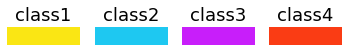

In [ ]:
palet = [(250, 230, 20), (30, 200, 241), (200, 30, 250), (250,60,20)]

fig, ax = plt.subplots(1, 4, figsize=(6, 2))
for i in range(4):
    ax[i].axis('off')
    ax[i].imshow(np.ones((10, 40, 3), dtype=np.uint8) * palet[i])
    ax[i].set_title("class{}".format(i+1))

plt.show()

In [ ]:
def mask2rgba(mask):
    rgba_list = []
    for idx in range(4):    # idx: class id
        rgba = cv2.cvtColor(mask[:, :, idx], cv2.COLOR_GRAY2RGBA)
        rgba[:, :, :3] = rgba[:, :, :3] /255 * palet[idx]
        rgba_list.append(rgba)
    return rgba_list

In [ ]:
def make_mask(row_id):
    fname = train_df.iloc[row_id].name

    labels = train_df.iloc[row_id][:4]
    masks = np.zeros((256, 1600, 4), dtype=np.uint8)    # 4:class 1～4 (ch:0～3)

    for idx, label in enumerate(labels.values):
        if label is not np.nan:
            label = label.split(" ")
            positions = map(int, label[0::2])
            length = map(int, label[1::2])
            mask = np.zeros(256 * 1600, dtype=np.uint8)
            for pos, le in zip(positions, length):
                mask[pos:(pos + le)] = 255
            masks[:, :, idx] = mask.reshape(256, 1600, order='F')
    return fname, masks

In [ ]:
def show_mask_image(row_id, contour = True):
    name, mask = make_mask(row_id)
    img = cv2.imread(os.path.join(DIRtrain, name))

    if contour:
        for ch in range(4):
            contours, _ = cv2.findContours(mask[:, :, ch],
                            cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)
            for i in range(0, len(contours)):
                cv2.polylines(img, contours[i], True, palet[ch], 2)
    else:
        for ch in range(4):
            img[mask[:,:,ch]==255] = palet[ch]
        
    fig, ax = plt.subplots(figsize=(7,7))
    ax.set_title(name)
    ax.imshow(img)
    ax.axis('off')
    plt.show()

In [ ]:
# classify defects
idx_class_1 = list(filter(lambda r:not pd.isna(train_df.iloc[r,0]), range(len(train_df))))
idx_class_2 = list(filter(lambda r:not pd.isna(train_df.iloc[r,1]), range(len(train_df))))
idx_class_3 = list(filter(lambda r:not pd.isna(train_df.iloc[r,2]), range(len(train_df))))
idx_class_4 = list(filter(lambda r:not pd.isna(train_df.iloc[r,3]), range(len(train_df))))
# Nomber of defects class
idx_no_defect = list(filter(lambda r:train_df.iloc[r,4] == 0, range(len(train_df))))
idx_1_defect = list(filter(lambda r:train_df.iloc[r,4] == 1, range(len(train_df))))
idx_class_multi = list(filter(lambda r:train_df.iloc[r,4] >= 2, range(len(train_df))))

### 1. visualize the images with no defects

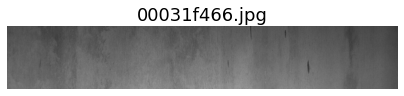

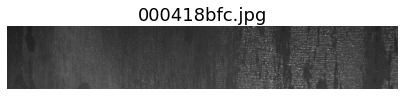

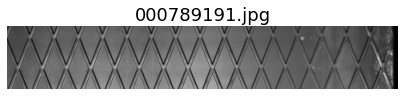

In [ ]:
# no defect sumple
for idx in idx_no_defect[:3]:
    show_mask_image(idx, contour=False)

### 2. visualize the images with defects (class = 1, yellow)

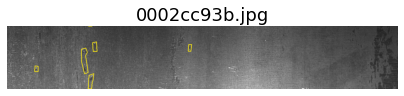

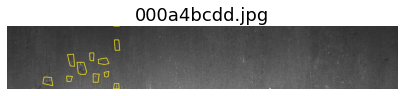

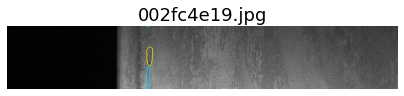

In [ ]:
# class_1 defect sumple (Yellow)
for idx in idx_class_1[:3]:
    show_mask_image(idx, contour=True)

### 3. visualize the images with defects (class = 2, lighe blue)

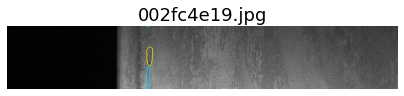

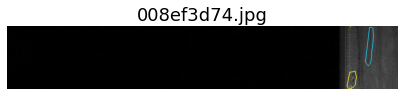

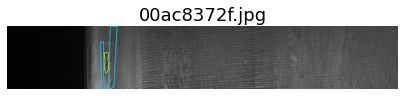

In [ ]:
# class_2 defect sumple (lightblue)
for idx in idx_class_2[:3]:
    show_mask_image(idx, contour=True)

### 4. visualize the images with defects (class = 3, purple)

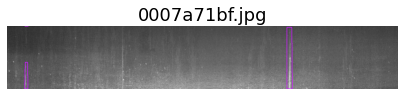

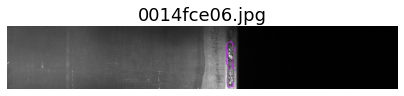

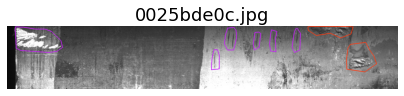

In [ ]:
# class_3 defect sumple (purple)
for idx in idx_class_3[:3]:
    show_mask_image(idx, contour=True)

### 5. visualize the images with defects (class = 4, red)

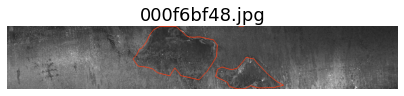

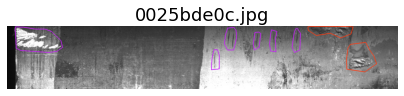

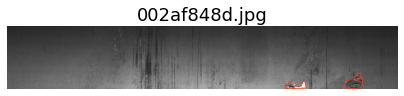

In [ ]:
# class_4 defect sumple (red)
for idx in idx_class_4[:3]:
    show_mask_image(idx, contour=True)

### 6. visualize the images with multi defects

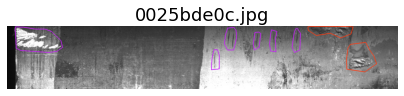

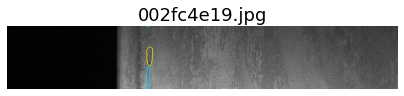

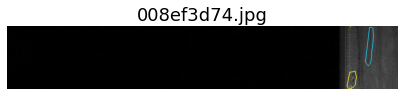

In [ ]:
# contain multi class defects
for idx in idx_class_multi[:3]:
    show_mask_image(idx, contour=True)

## Part 3: Model building

### 1. Use U-Net model for object detection & segmentation

In [ ]:
##### Training conditions ##### 
batch_size = 32

NoTRAIN = True    # True:No further training, use pre-learned weights
RESUME = True    # True:Resume Training, False:Start from the beginning

if RESUME:
    initial_epoch = 180    # initial_epoch when training resumes
else:
    initial_epoch = 0
epochs = initial_epoch + 20
steps_per_epoch = 100

In [ ]:
# U-Net
# https://www.kaggle.com/jesperdramsch/intro-chest-xray-dicom-viz-u-nets-full-data#Vanilla-Unet

input_shape = (256, 1600, 1)
inputs = Input(input_shape)

c1 = Conv2D(8, (3, 3), activation='relu', padding='same') (inputs)
c1 = Conv2D(8, (3, 3), activation='relu', padding='same') (c1)
p1 = MaxPooling2D((2, 2)) (c1)

c2 = Conv2D(16, (3, 3), activation='relu', padding='same') (p1)
c2 = Conv2D(16, (3, 3), activation='relu', padding='same') (c2)
p2 = MaxPooling2D((2, 2)) (c2)

c3 = Conv2D(32, (3, 3), activation='relu', padding='same') (p2)
c3 = Conv2D(32, (3, 3), activation='relu', padding='same') (c3)
p3 = MaxPooling2D((2, 2)) (c3)

c4 = Conv2D(64, (3, 3), activation='relu', padding='same') (p3)
c4 = Conv2D(64, (3, 3), activation='relu', padding='same') (c4)
p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

c5 = Conv2D(64, (3, 3), activation='relu', padding='same') (p4)
c5 = Conv2D(64, (3, 3), activation='relu', padding='same') (c5)
p5 = MaxPooling2D(pool_size=(2, 2)) (c5)

c55 = Conv2D(128, (3, 3), activation='relu', padding='same') (p5)
c55 = Conv2D(128, (3, 3), activation='relu', padding='same') (c55)

u6 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c55)
u6 = concatenate([u6, c5])
c6 = Conv2D(64, (3, 3), activation='relu', padding='same') (u6)
c6 = Conv2D(64, (3, 3), activation='relu', padding='same') (c6)

u71 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c6)
u71 = concatenate([u71, c4])
c71 = Conv2D(32, (3, 3), activation='relu', padding='same') (u71)
c61 = Conv2D(32, (3, 3), activation='relu', padding='same') (c71)

u7 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c61)
u7 = concatenate([u7, c3])
c7 = Conv2D(32, (3, 3), activation='relu', padding='same') (u7)
c7 = Conv2D(32, (3, 3), activation='relu', padding='same') (c7)

u8 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c7)
u8 = concatenate([u8, c2])
c8 = Conv2D(16, (3, 3), activation='relu', padding='same') (u8)
c8 = Conv2D(16, (3, 3), activation='relu', padding='same') (c8)

u9 = Conv2DTranspose(8, (2, 2), strides=(2, 2), padding='same') (c8)
u9 = concatenate([u9, c1], axis=3)
c9 = Conv2D(8, (3, 3), activation='relu', padding='same') (u9)
c9 = Conv2D(8, (3, 3), activation='relu', padding='same') (c9)

outputs = Conv2D(4, (1, 1), activation='sigmoid') (c9)

model = Model(inputs=[inputs], outputs=[outputs])

# Load pre-traind weights
if (NoTRAIN or RESUME) and os.path.exists(weights_path):
    model.load_weights(weights_path)

model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 256, 1600, 1) 0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 1600, 8) 80          input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 256, 1600, 8) 584         conv2d_1[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)  (None, 128, 800, 8)  0           conv2d_2[0][0]                   
____________________________________________________________________________________________

In [ ]:
def dice_coef(y_true, y_pred, smooth=1):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) \
            / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

In [ ]:
optimizer = Adam()
model.compile(optimizer, 'binary_crossentropy', metrics=[dice_coef])

### 2. training dataset & validation dataset preparation

#### 2.1 Without Augumentation

In [ ]:
# Train Data Generator
def Xy_generator(ids, batch_size):
    Xs = []; ys = []
    while True:
        for i in ids:
            name, mask = make_mask(i)
            img = cv2.imread(os.path.join(DIRtrain, name),
                             cv2.IMREAD_GRAYSCALE)
            img = img[..., np.newaxis]    # Add channel axis
            img = img / 255.           # 0～1
            mask = mask / 255.         # 0～1
            Xs.append(img); ys.append(mask)
            if len(Xs) == batch_size:
                X = np.array(Xs); y = np.array(ys)
                Xs = []; ys = []
                yield [X, y]

#### 2.2 With Augumentation

In [ ]:
# Train Data Generator with Augumentation
# we create two instances with the same arguments 

data_gen_args = dict(featurewise_center=True,
                     featurewise_std_normalization=True,
                     rotation_range=5.,
                     width_shift_range=0.5,
                     height_shift_range=0.5,
                     zoom_range=0.2,
                     horizontal_flip=True,
                     vertical_flip=True,
                     fill_mode = 'wrap') 
image_datagen = ImageDataGenerator(**data_gen_args) 
mask_datagen = ImageDataGenerator(**data_gen_args)

# Provide the same seed and keyword arguments to the fit and flow methods 
seed = 1 

# Train Data Generator
def Xy_generator(ids, batch_size):
    Xs = []; ys = []
    while True:
        for i in ids:
            name, mask = make_mask(i)
            img = cv2.imread(os.path.join(DIRtrain, name),
                             cv2.IMREAD_GRAYSCALE)
            img = img[..., np.newaxis]    # Add channel axis
            img = img / 255.           # 0～1
            mask = mask / 255.         # 0～1

            Xs.append(img); ys.append(mask)
            if len(Xs) == batch_size:
                image_datagen.fit(Xs, augment=True, seed=seed) 
                mask_datagen.fit(ys, augment=True, seed=seed)               
                X = np.array(Xs); y = np.array(ys)
                Xs = []; ys = []
                yield [X, y]

In [ ]:
batch_size = 32
# Train Data
train_ids, val_ids = train_test_split(range(len(train_df)), test_size=0.2, random_state=42)
train_gen = Xy_generator(train_ids, batch_size)
val_gen = Xy_generator(val_ids, batch_size)

X.shape: (4, 256, 1600, 1) 
y.shape: (4, 256, 1600, 4)


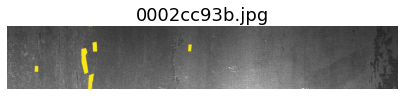

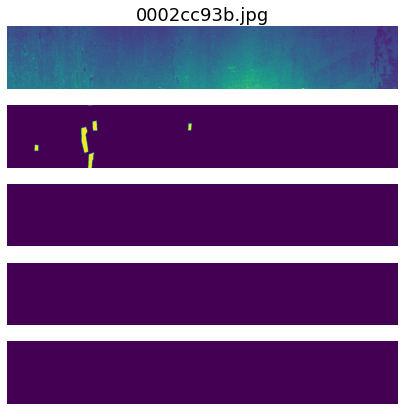

In [ ]:
# generator test
for X, y in Xy_generator(range(len(train_df)), 4):
    break

print('X.shape:',X.shape, '\ny.shape:',y.shape)

row = 0
# from train_df
show_mask_image(row, contour=False)
# from generator
fig, axs = plt.subplots(5, figsize=(7,7))
axs[0].imshow(X[row,:,:,0])
axs[0].axis('off')
axs[0].set_title(train_df.iloc[row].name)
for i in range(4):
    axs[i+1].imshow(y[row,:,:,i])
    axs[i+1].axis('off')

### 3. model training/fitting

In [ ]:
# Callback
checkpoint = ModelCheckpoint(weights_path, monitor='val_dice_coef',
                             verbose=1,save_best_only=True, mode='max', period=1)
#checkpoint = ModelCheckpoint("DefectDetection.h5", monitor='val_dice_coef',
#                             verbose=1,save_best_only=True, mode='max')

callbacks_list = [checkpoint]

In [ ]:
if NoTRAIN == False or RESUME:
    history = model.fit_generator(generator=train_gen,
                              steps_per_epoch=steps_per_epoch,
                              initial_epoch=initial_epoch,
                              epochs=epochs,
                              validation_data=val_gen,
                              validation_steps = len(val_ids)//batch_size,
                              verbose=2,
                              shuffle=True,
                              callbacks=callbacks_list)

Epoch 181/200
 - 2121s - loss: 0.0075 - dice_coef: 0.7172 - val_loss: 0.0103 - val_dice_coef: 0.6822

Epoch 00181: val_dice_coef improved from -inf to 0.68224, saving model to /content/drive/My Drive/CSTU1 - Steel/DefectDetection.h5
Epoch 182/200
 - 1889s - loss: 0.0081 - dice_coef: 0.6889 - val_loss: 0.0061 - val_dice_coef: 0.6853

Epoch 00182: val_dice_coef improved from 0.68224 to 0.68528, saving model to /content/drive/My Drive/CSTU1 - Steel/DefectDetection.h5
Epoch 183/200
 - 1877s - loss: 0.0085 - dice_coef: 0.6873 - val_loss: 0.0097 - val_dice_coef: 0.6868

Epoch 00183: val_dice_coef improved from 0.68528 to 0.68679, saving model to /content/drive/My Drive/CSTU1 - Steel/DefectDetection.h5
Epoch 184/200
 - 1108s - loss: 0.0078 - dice_coef: 0.7076 - val_loss: 0.0107 - val_dice_coef: 0.6925

Epoch 00184: val_dice_coef improved from 0.68679 to 0.69253, saving model to /content/drive/My Drive/CSTU1 - Steel/DefectDetection.h5
Epoch 185/200
 - 1048s - loss: 0.0075 - dice_coef: 0.7057 -

In [ ]:
# Plot the loss and dice_coef curves
if (NoTRAIN or RESUME) and os.path.exists(history_path):
    hist_df = pd.read_csv(history_path)        # Load previous training history
elif RESUME and os.path.exists(history_path):
    hist_df1 = pd.DataFrame(history.history)[['loss','val_loss','dice_coef','val_dice_coef']]
    hist_df = pd.concat([hist_df, hist_df1], ignore_index=True)    # Concat history
else: #NoTRAIN == False and RESUME == False:
    hist_df = pd.DataFrame(history.history)[['loss','val_loss','dice_coef','val_dice_coef']]

In [ ]:
# Plot
fig, ax = plt.subplots(1, 2, figsize=(16, 5))

ax[0].plot(hist_df['loss'], color='b', label="Training loss")
ax[0].plot(hist_df['val_loss'], color='r', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(hist_df['dice_coef'], color='b', label="Training dice_coef")
ax[1].plot(hist_df['val_dice_coef'], color='r',label="Validation dice_coef")
legend = ax[1].legend(loc='best', shadow=True)

In [ ]:
# Save history (for next Resume)
hist_df.to_csv("DefectDetection_history.csv", index=False)

##Part 4 Validation Data Post Processing and Analysis

Various computer vision techniques are used to further improve the defect detection results.
1. threshold
2. erosion / dilation
3. min_size filter (for each defect area)
4. min_total_defect picso filter (for each mask)

In [ ]:
# Binarize the mask output by NN
def binarize(masks, th = 0.5):
    # Maximum value of each channel per pixel
    mask_max = np.zeros_like(masks[:,:,0])
    mask_max = np.fmax(masks[:,:,0],masks[:,:,1])
    mask_max = np.fmax(mask_max,masks[:,:,2])
    mask_max = np.fmax(mask_max,masks[:,:,3])         #mask_max is mask for the defects with the highest likelihood. 
    # Remove non-maximum pixels
    m = np.zeros_like(masks)
    for ch in range(4):
        m[:,:,ch] = (masks[:,:,ch] == mask_max) * masks[:,:,ch]
    # Binarization
    m = (m>th) * 1
    return m

In [ ]:
#Morphological Transformations

def MorphTrans(masks):
    erosion_kernal = np.ones((7, 7), np.uint8)
    dilation_kernal = np.ones((9, 9), np.uint8)
    new_masks = new_masks = np.zeros((256, 1600, 4))
    for i in range(4):
        img = cv2.erode(masks[:,:,i].astype(np.uint8), erosion_kernal, iterations=1)
        new_img = cv2.dilate(img, dilation_kernal, iterations=1)
        new_masks[:,:,i] = new_img[:,:]

    return new_masks


In [ ]:
#Filter1
'''Post processing of each predicted mask, components with lesser number of pixels
    than `min_size` are ignored'''

def filter1(masks, threshold = 0.5, min_size = [200, 200, 500, 500], defect_size = [600, 600, 900, 2000]):
    new_masks = np.zeros((256, 1600, 4))

    for i in range(4):
        mask = cv2.threshold(masks[:,:,i], threshold, 1, cv2.THRESH_BINARY)[1]
#        mask = masks[:,:,i]   # if doing binarize seperately
        if np.sum(mask) > defect_size[i]:
            num_component, component = cv2.connectedComponents(mask.astype(np.uint8))
            for c in range(1, num_component):
                p = (component == c)
                if p.sum() > min_size[i]:
                    new_masks[:,:,i][p] = 1
    return new_masks


In [ ]:
#Filter2 
'''to filter out small defects _ Another try'''

from sklearn.cluster import DBSCAN
def filter2(masks, min_size={1:150, 2:150, 3:150, 4:150}):
    defects={}
    for idx in range(4):
        defects[idx+1]=np.argwhere(masks[:,:,idx])

    clusters={}
    for idx in defects.keys():
        if len(defects[idx])>0:
#            clusters[idx] = DBSCAN(eps=3, min_samples=3, metric='manhattan').fit(defects[idx])
            clusters[idx] = DBSCAN(eps=3, min_samples=3, metric='euclidean').fit(defects[idx])
    new_masks = np.zeros((256, 1600, 4))    
    for defect in clusters.keys():
        region=set(clusters[defect].labels_)

        new_mask=np.zeros(256*1600)        
        for r in region:
            if r!=-1: # ignore clusters with -1 label (noise)
                args=np.argwhere(clusters[defect].labels_==r).flatten()
                if len(args)>=min_size[defect]:
                    for xy in defects[defect][args]:
                        new_mask[xy[0]+xy[1]*256] = 1                        
                    new_masks[:,:,defect-1]=new_mask.reshape(256,1600, order="F")

    return new_masks

In [ ]:
#Calculate the dice_coef for each class seperately
def dice_coef2(y_true, y_pred, smooth=1):
    res = 0
    for i in range(4):
        y_true_f = K.flatten(y_true[i])
        y_pred_f = K.flatten(y_pred[i])
        intersection = K.sum(y_true_f * y_pred_f)
        res += (2 * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth) / 4
    return res

In [ ]:
from tqdm import tqdm

In [ ]:
##Mean Dice coefficient for Validation##
mean_dice_coef = 0
mean_dice_coef_2 = 0
total_dice_coef_3 = 0
#predict mask
n = len(val_ids)
img_w_defects = 0
for ids in tqdm(val_ids, total = n):
    name, mask = make_mask(ids)
    img = cv2.imread(os.path.join(DIRtrain, name),
          cv2.IMREAD_GRAYSCALE)    

    img = img[..., np.newaxis]    # Add channel axis
    img = img[np.newaxis, ...]    # Add butch axis
    img = img / 255.              # 0～1
    mask = mask / 255.            
    pred_masks = model.predict(img)[0]
#filter1 / binarize
#    pred_masks = binarize(pred_masks, th = 0.5)
    pred_masks = filter1(pred_masks, threshold = 0.5, min_size = [50, 50, 100, 200], defect_size = [800, 800, 1200, 3000])
#Morphological Transformations
    pred_masks = MorphTrans(pred_masks)
#apply filter2
#    pred_masks = filter2(pred_masks, min_size={1:200, 2:200, 3:200, 4:200})
#calculate Mean Dice coefficient
    pred_masks = pred_masks.astype('double')
    mean_dice_coef += dice_coef(mask, pred_masks, smooth=1)/n

#calculate Mean Dice coefficient 2
    mean_dice_coef_2 += dice_coef2(mask, pred_masks, smooth=1)/n

#Mean Dice coefficient 3 can be calculated off-line from Mean Dice coefficient 1 & 2

#calculate Mean Dice coefficient 4
    if K.sum(K.flatten(mask)) > 0:
        img_w_defects += 1
        total_dice_coef_4 += dice_coef(mask, pred_masks, smooth=1)

mean_dice_coef_3 = total_dice_coef_4 / img_w_defects

print('mean_dice_coef:', mean_dice_coef)
print('mean_dice_coef_2:', mean_dice_coef_2)
print('mean_dice_coef_4:', mean_dice_coef_4)
print('img_w_defects:', img_w_defects)



100%|██████████| 2514/2514 [02:45<00:00, 15.16it/s]

mean_dice_coef: tf.Tensor(0.7602519146890261, shape=(), dtype=float64)
mean_dice_coef_2: tf.Tensor(0.7875320172402177, shape=(), dtype=float64)
mean_dice_coef_3: tf.Tensor(0.6012339742926548, shape=(), dtype=float64)
img_w_defects: 1336


## Part 5: Test data Prediction

In [ ]:
# Load the weights that had the best score for predict
#if NoTRAIN == False or RESUME:
#model.load_weights("DefectDetection.h5")
model.load_weights(weights_path)

In [ ]:
# Binarize the mask output by NN
def binarize(masks, th = 0.5):
    # Maximum value of each channel per pixel
    mask_max = np.zeros_like(masks[:,:,0])
    mask_max = np.fmax(masks[:,:,0],masks[:,:,1])
    mask_max = np.fmax(mask_max,masks[:,:,2])
    mask_max = np.fmax(mask_max,masks[:,:,3])         #mask_max is mask for the defects with the highest likelihood. 
    # Remove non-maximum pixels
    m = np.zeros_like(masks)
    for ch in range(4):
        m[:,:,ch] = (masks[:,:,ch] == mask_max) * masks[:,:,ch]
    # Binarization
    m = (m>th) * 1
    return m

In [ ]:
def show_predict_img(df, row):
    if df == "train_df":
        name = train_df.iloc[row].name
        img = cv2.imread(os.path.join(DIRtrain, name),
                             cv2.IMREAD_GRAYSCALE)
    else:
        if df == "submit_df":
            name = test_df.iloc[row//4,0].split('_')[0]
        elif df == "test_df":
            name = test_df.iloc[row,0]
        img = cv2.imread(os.path.join(DIRtest, name),
                             cv2.IMREAD_GRAYSCALE)

    img_ = img[..., np.newaxis]    # Add channel axis
    img_ = img_[np.newaxis, ...]    # Add batch axis
    img_ = img_ / 255.              # 0～1

    pred_masks = model.predict(img_)
    bin_masks = binarize(pred_masks[0, ...], 0.5)

    fig, axs = plt.subplots(5,2, figsize=(12, 6))
    axs[0,0].imshow(img)
    axs[0,0].axis('off')
    axs[0,0].set_title(name)
    axs[0,1].axis('off')
    axs[0,1].set_title("after binarize")
    for i in range(4):
        axs[i+1,0].imshow(pred_masks[0,:,:,i])
        axs[i+1,0].axis('off')
        axs[i+1,0].set_title('class '+ str(i+1))
        axs[i+1,1].imshow(bin_masks[:,:,i])
        axs[i+1,1].axis('off')
        axs[i+1,1].set_title('class '+ str(i+1))

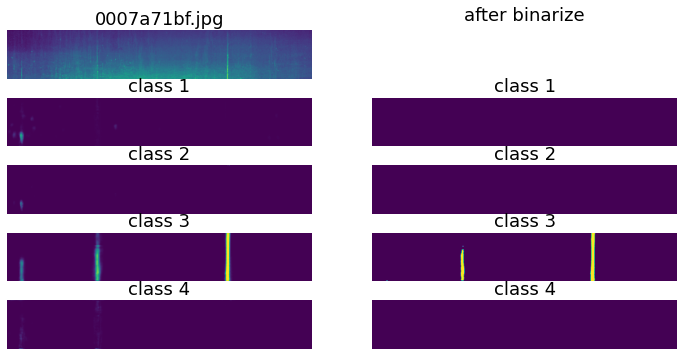

In [ ]:
# predict sumple
show_predict_img("train_df", 4)

## Part 6: Kaggle Submission

### Sample

In [ ]:
from tqdm import tqdm

In [ ]:
#submit_df = pd.read_csv("/content/sample_submission.csv")
submit_df = pd.read_csv("/content/drive/My Drive/CSTU1 - Steel/sample_submission.csv")
submit_df['EncodedPixels'] = np.nan
submit_df.head(5)

,ImageId_ClassId,EncodedPixels
0,004f40c73.jpg_1,NaN
1,004f40c73.jpg_2,NaN
2,004f40c73.jpg_3,NaN
3,004f40c73.jpg_4,NaN
4,006f39c41.jpg_1,NaN


### Submission

In [ ]:
temp_df = pd.DataFrame()
temp_df['ImageId'] = submit_df['ImageId_ClassId'].apply(lambda x: x.split('_')[0])    #copy "ImageId" from submit_df 
test_df = pd.DataFrame(temp_df['ImageId'].unique(), columns=['ImageId'])              #keep only the unique
test_df.head()

,ImageId
0,004f40c73.jpg
1,006f39c41.jpg
2,00b7fb703.jpg
3,00bbcd9af.jpg
4,0108ce457.jpg


In [ ]:
def mask2rle(mask):                                               #run-length encoding on the pixel values
    pixels= mask.T.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[:-1:2]
    return ' '.join(str(x) for x in runs)

In [ ]:
def build_rles(masks):
    width, height, depth = masks.shape
    masks = binarize(masks, th = 0.5)
    rles = [mask2rle(masks[:, :, i]) for i in range(depth)]

    return rles

In [ ]:
# Predict test images
for i, line in tqdm(test_df.iterrows()):
    img = cv2.imread(os.path.join(DIRtest, line['ImageId']),
                     cv2.IMREAD_GRAYSCALE)
    img = img[..., np.newaxis]    # Add channel axis
    img = img[np.newaxis, ...]    # Add butch axis
    img = img / 255.              # 0～1
    pred_masks = model.predict(img)[0]
    rles = build_rles(pred_masks)
    for j in range(4):
        if len(rles[j])>0:
            submit_df.iloc[i*4+j,1] = rles[j]

1801it [10:37,  2.82it/s]


In [ ]:
submit_df.head(30)

,ImageId_ClassId,EncodedPixels
0,004f40c73.jpg_1,NaN
1,004f40c73.jpg_2,NaN
2,004f40c73.jpg_3,NaN
3,004f40c73.jpg_4,NaN
4,006f39c41.jpg_1,NaN
5,006f39c41.jpg_2,NaN
6,006f39c41.jpg_3,NaN
7,006f39c41.jpg_4,NaN
8,00b7fb703.jpg_1,NaN
9,00b7fb703.jpg_2,NaN


In [ ]:
# Number of Defect Detection
submit_df['EncodedPixels'].count()

1279

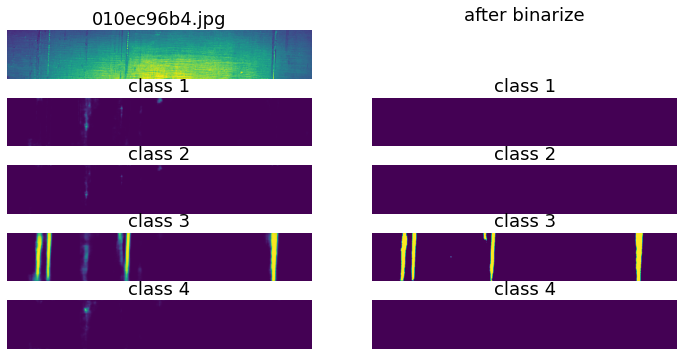

In [ ]:
# Detected sumple
show_predict_img("submit_df",26)

In [ ]:
submit_df.to_csv('/content/drive/My Drive/CSTU1 - Steel/submission_v3.csv', index=False)

## Summary

1. An U-net model is build for classification and segmentation of steel defects.
2. The challenge is that the training data is highly un-balanced and many images have no defects.
3. The model is trained with augmentations on the images and masks
4. Various computer vision techniques are used in post-processing to further improve the detection.
5. Dice coefficient of 0.79 is achived.


###Useful reference:
URL_1 = https://www.kaggle.com/amanooo/defect-detection-starter-u-net